In [123]:
import os
import requests
import matplotlib.pyplot as plt
import tarfile
import torch
import shutil

from enum import Enum
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import v2

In [2]:
class Pix2PixDataset(Enum):
        CITYSCAPES = 'cityscapes'
        EDGES2HANDBAGS = 'edges2handbags'
        EDGES2SHOES = 'edges2shoes'
        FACADES = 'facades'
        MAPS = 'maps'
        NIGHT2DAY = 'night2day'
        
        def get_url(self):
            return f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{self.value}.tar.gz'

In [155]:
class ImageDataset(Dataset):    
    def __init__(self, dataset: Pix2PixDataset):
        self.dataset = dataset
        self.data_folder = './data'
        self.preprocess = v2.Compose([
            v2.Resize([286, 286]),
            v2.RandomCrop([256, 256]),
            v2.ToDtype(torch.float32, scale=True)])

    @staticmethod
    def __download_dataset__(url, dataset_path):
        response = requests.get(url)
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)
        file_name = url.split('/')[-1]
        dataset_path = os.path.join(dataset_path, file_name)
        with open(dataset_path, 'wb') as f:
            f.write(response.content)
        return dataset_path
    
    @staticmethod
    def __extract_dataset__(path, datafile):
        with tarfile.open(datafile, 'r') as tar:
            tar.extractall(path, filter='data')
        os.remove(datafile)
    
    @staticmethod
    def remove_dataset(path):
        shutil.rmtree(path)

    def load_dataset(self):
        self.data_file = ImageDataset.__download_dataset__(self.dataset.get_url(), self.data_folder)
        ImageDataset.__extract_dataset__(self.data_folder, self.data_file)

    def get_image_paths(self, test = False):
        path = self.data_folder + '/' + self.dataset.value
        if test:
            path += '/test'
        else:
            path += '/train'
        self.img_paths = []
        for root, _, fnames in sorted(os.walk(path)):
            for fname in fnames:
                img_path = os.path.join(root, fname)
                self.img_paths.append(img_path)
    
    def __getitem__(self,  index):
        img_path = self.img_paths[index]
        img = read_image(img_path)
        _, h, w = img.size()
        w2 = int(w/2)
        x = self.preprocess(v2.functional.crop(img, 0, 0, w2, h))
        y = self.preprocess(v2.functional.crop(img, 0, w2, w2, h))
        return {'x':x, 'y':y}

In [156]:
dataset = ImageDataset(dataset=Pix2PixDataset.FACADES)

In [128]:
dataset.load_dataset()

In [157]:
dataset.get_image_paths()

[]

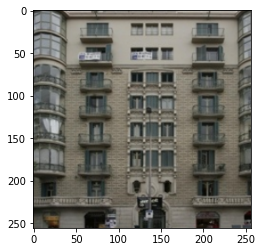

In [159]:
img = dataset.__getitem__(1)['x']
plt.figure()
plt.imshow(img.permute(1, 2, 0))
plt.plot()